## Import Package

In [67]:
# required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numba as nb
import warnings
from datetime import datetime
import gc

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample

# display set up
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 3)
pd.options.display.max_rows = 999

## Load Data

In [7]:
# Functions for memory reduction
@nb.jit()
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return(df)

In [183]:
%%time

prop_2016 = pd.read_csv('data/prop_2016_v2.csv')
prop_2016 = reduce_mem_usage(prop_2016)

prop_2017 = pd.read_csv('data/prop_2017_v2.csv')
prop_2017 = reduce_mem_usage(prop_2017)

train = pd.read_csv('data/train_v2.csv')
train = reduce_mem_usage(train)

Mem. usage decreased to 999.27 Mb (75.6% reduction)
Mem. usage decreased to 999.27 Mb (75.6% reduction)
Mem. usage decreased to 58.44 Mb (75.3% reduction)
CPU times: user 4min, sys: 2min 33s, total: 6min 34s
Wall time: 7min 5s


## Modeling Prep

In [184]:
%%time
def encoding(train, prop_2016, prop_2017, categorical_features):
    """
    To limit the value to small numbers since values in categorical_feature is suggested to be small.
    Now the number denoting missing values will be 0 instead of -1.
    """
    from category_encoders import BinaryEncoder
    
    split_index = [len(train), len(prop_2016), len(prop_2017)]
    
    
    prop = pd.concat([train[categorical_features],
                      prop_2016[categorical_features], 
                      prop_2017[categorical_features]], ignore_index=True)
    
    encoder = BinaryEncoder(cols=categorical_features, drop_invariant = True)
    transformed = encoder.fit_transform(prop)
    train_be = transformed.iloc[: split_index[0]].reset_index(drop=True)
    prop_2016_be = transformed.iloc[split_index[0] : split_index[0]+split_index[1]].reset_index(drop=True)
    prop_2017_be = transformed.iloc[split_index[0]+split_index[1]:].reset_index(drop=True)
    

    train = pd.concat([train.drop(columns=categorical_features).reset_index(drop=True), train_be], axis = 1)
    prop_2016 = pd.concat([prop_2016.drop(columns=categorical_features).reset_index(drop=True), prop_2016_be], axis = 1)
    prop_2017 = pd.concat([prop_2017.drop(columns=categorical_features).reset_index(drop=True), prop_2017_be], axis = 1)
    
    train = train.drop(columns = ['trans_month', 'trans_year', 'trans_quarter'])
    
    del prop, transformed, train_be, prop_2016_be, prop_2017_be
    gc.collect()
    return(train, prop_2016, prop_2017)

# Do encoding for cateogircal features
categorical_features = ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid',
              'fips', 'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid',
              'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip',
              'storytypeid', 'typeconstructiontypeid', 'geo_cluster']

train, prop_2016, prop_2017 = encoding(train, prop_2016, prop_2017, categorical_features)

CPU times: user 1min 38s, sys: 1min 34s, total: 3min 12s
Wall time: 4min 32s


In [185]:
# Transform to Numpy matrices
X = train.drop(columns=['logerror', 'parcelid', 'transactiondate'])
y = train.logerror.values.astype(float)


# Get categorical features
categorical_indices = []
for i, n in enumerate(X.columns):
    if n in categorical_features:
        categorical_indices.append(i)

# Perform shuffled train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



# Keep outlier values (roughly outside 99% percentile) out of the training dataset
# outlier_threshold = 0.4
# mask = (abs(y_train) <= outlier_threshold)
# X_train = X_train.iloc[mask, :]
# y_train = y_train[mask]

print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_val shape: {}".format(X_test.shape))
print("y_val shape: {}".format(y_test.shape))

X_train shape: (134310, 211)
y_train shape: (134310,)
X_val shape: (33578, 211)
y_val shape: (33578,)


## Hyperparameter Tuning

We will conduct bayesian hyperparameter tuning with the help of the package `HyperOpt`

In [186]:
# CatBoost parameters Setting
params = {'loss_function': 'MAE',
          'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
          'depth': hp.choice('depth', np.arange(2, 10, dtype=int)),
          'random_strength': hp.choice('random_strength', np.arange(1, 10, dtype=int)),
         'eval_metric': 'MAE',
         'nan_mode': 'Min',
         'iterations': 1000,
         'od_pval': hp.uniform('od_pval', 0.00001, 0.01),
          'l2_leaf_reg': hp.choice('l2_leaf_reg', [1,3,5,7,11,21,41,81,100]),
          'border_count': hp.choice('border_count', [2,4,8,16,32,64,128,256,512,1024])
         }

In [192]:
def tuning_hyperparam_cat(X, y, num_eval, metric = mean_absolute_error, param = params):
    """
    Wrapper Function for the entire bayesian hyperparameter tuning process. 
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    
    # tuning hyperparameter
    print("Tuning hyperparameter for the output model.")
    t = datetime.now()
    results_hyperopt = hyperopt(param, X_train, y_train, X_test, y_test, num_eval)
    
    # Retrieve Hyperopt scores
    hyperopt_scores = [trial['result']['loss']*-1 for trial in results_hyperopt.trials]
    hyperopt_scores = np.maximum.accumulate(hyperopt_scores)
    
    # plotting
    plot_learning_curve(hyperopt_scores, num_eval = num_eval)
    
    # retrieve best results
    best = results_hyperopt.best_trial['misc']['vals']
    
    clf = CatBoostRegressor(iterations = 30,
                            eval_metric = 'MAE',
                            loss_function = 'MAE',
                            learning_rate = np.float(best['learning_rate'][0]),
                            depth = np.int(best['depth'][0]),
                            random_strength = np.int(best['random_strength'][0]),
                            od_pval = np.float(best['od_pval'][0]),
                            l2_leaf_reg = np.int(best['l2_leaf_reg'][0]),
                            border_count = np.int(best['border_count'][0])
    )
    
    print("Complete.")
    print(f"Time used: {datetime.now() - t}")
    print("")
    return(clf)

In [191]:
def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval):
    """
    Main hyperparameter tuning function.
    """
    start = time.time()
    
    def objective_function(params):
        clf = CatBoostRegressor(verbose=False, **params).fit(X_train, y_train)
        pred = clf.predict(X_test)
        return {'loss': mean_absolute_error(y_test, pred), 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials)    
    return(trials)

In [193]:
def plot_learning_curve(hyperopt_scores, num_eval):
    """
    Plot hyperparameter learning curve.
    """
    f, ax = plt.subplots(figsize=(7,6))
    sns.set_palette("husl")
    sns.despine()
    ax = sns.lineplot(x=[x for x in range(num_eval)], y=hyperopt_scores, linewidth = 2)
    plt.title("Finding the optimum", fontsize=18)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Cross-Validation Score (accuracy, %)', fontsize=12)
    plt.legend(loc='lower right', labels=['Hyperopt'])
    plt.setp(ax.get_legend().get_texts(), fontsize='12')

Tuning hyperparameter for the output model.
100%|██████████| 100/100 [1:12:22<00:00, 43.42s/it, best loss: 0.06754219971883009]
Complete.
Time used: 1:12:22.395959



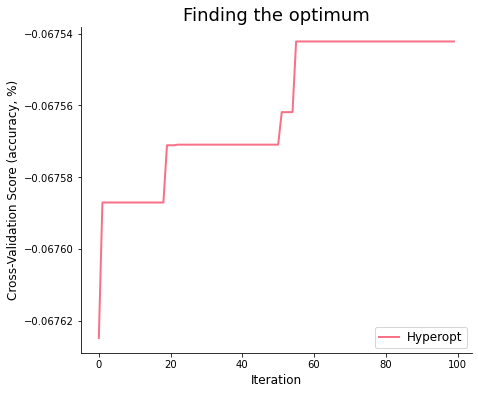

In [194]:
clf = tuning_hyperparam_cat(X_train, y_train, num_eval=100)

In [195]:
params = clf.get_params()
params

{'iterations': 30,
 'learning_rate': 0.0364,
 'depth': 4,
 'l2_leaf_reg': 7,
 'loss_function': 'MAE',
 'border_count': 4,
 'od_pval': 0.0044,
 'random_strength': 0,
 'eval_metric': 'MAE'}

In [2]:
# def encoding(train, prop_2016, prop_2017, categorical_features):
#     """
#     To limit the value to small numbers since values in categorical_feature is suggested to be small.
#     Now the number denoting missing values will be 0 instead of -1.
#     """
#     from sklearn.preprocessing import LabelEncoder
    
#     prop = pd.concat([train[categorical_features],
#                       prop_2016[categorical_features], 
#                       prop_2017[categorical_features]], ignore_index=True)
    
#     for col in categorical_features:
#         encoder = LabelEncoder().fit(prop[col].astype(str))
#         train[col] = encoder.transform(train[col].astype(str))
#         prop_2016[col] = encoder.transform(prop_2016[col].astype(str))
#         prop_2017[col] = encoder.transform(prop_2017[col].astype(str))
#     del prop
#     gc.collect()
#     return(train, prop_2016, prop_2017)

In [1]:
# prop_2017.isna().sum()

In [3]:
# # Do encoding for cateogircal features
# categorical_features = ['airconditioningtypeid','buildingqualitytypeid',
#                         'hashottuborspa','heatingorsystemtypeid','pooltypeid2','pooltypeid7',
#                         'propertylandusetypeid','rawcensustractandblock',
#                         'regionidcity','regionidneighborhood','regionidzip', 'yearbuilt','assessmentyear',
#                         'taxdelinquencyflag','taxdelinquencyyear','geo_cluster']

# train, prop_2016, prop_2017 = encoding(train, prop_2016, prop_2017, categorical_features)

# # Transform to Numpy matrices
# # X = drop_features(train).drop(columns='logerror')
# X = train.drop(columns='logerror')
# y = train.logerror.values

# # Specify feature names
# feature_names = [col for col in X.columns]

# # Get categorical features
# categorical_indices = []
# for i, n in enumerate(X.columns):
#     if n in categorical_features:
#         categorical_indices.append(i)

# # Perform shuffled train/test split
# np.random.seed(910)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# # Keep outlier values (roughly outside 99% percentile) out of the training dataset
# outlier_threshold = 0.4
# mask = (abs(y_train) <= outlier_threshold)
# X_train = X_train.iloc[mask, :]
# y_train = y_train[mask]

# print("X_train shape: {}".format(X_train.shape))
# print("y_train shape: {}".format(y_train.shape))
# print("X_val shape: {}".format(X_test.shape))
# print("y_val shape: {}".format(y_test.shape))

In [47]:
# # CatBoost parameters Setting
# params = {'loss_function': 'MAE',
#          'eval_metric': 'MAE',
#          'nan_mode': 'Min',
#          'iterations': 3000,
#          'l2_leaf_reg': 5}

In [52]:
# %%time
# # Train CatBoost Regressor with cross-validated early-stopping
# test_pool = Pool(X_test, y_test.astype(np.float64), cat_features=categorical_indices)

# params['iterations'] = 3000
# model = CatBoostRegressor(**params)
# model.fit(X_train, y_train,
#           use_best_model=True, eval_set=test_pool, early_stopping_rounds=50, verbose=1)

# # Evaluate on train and validation sets
# print(f"Train score: {abs(model.predict(X_train) - y_train).mean() * 100}")
# print(f"Test score: {abs(model.predict(X_test) - y_test).mean() * 100}")

0:	learn: 0.0686533	test: 0.0695956	best: 0.0695956 (0)	total: 54.2ms	remaining: 2m 42s
1:	learn: 0.0686375	test: 0.0695817	best: 0.0695817 (1)	total: 106ms	remaining: 2m 39s
2:	learn: 0.0686211	test: 0.0695658	best: 0.0695658 (2)	total: 158ms	remaining: 2m 37s
3:	learn: 0.0686060	test: 0.0695506	best: 0.0695506 (3)	total: 206ms	remaining: 2m 34s
4:	learn: 0.0685920	test: 0.0695365	best: 0.0695365 (4)	total: 262ms	remaining: 2m 36s
5:	learn: 0.0685791	test: 0.0695259	best: 0.0695259 (5)	total: 351ms	remaining: 2m 55s
6:	learn: 0.0685661	test: 0.0695136	best: 0.0695136 (6)	total: 408ms	remaining: 2m 54s
7:	learn: 0.0685527	test: 0.0695021	best: 0.0695021 (7)	total: 472ms	remaining: 2m 56s
8:	learn: 0.0685398	test: 0.0694899	best: 0.0694899 (8)	total: 533ms	remaining: 2m 57s
9:	learn: 0.0685287	test: 0.0694805	best: 0.0694805 (9)	total: 585ms	remaining: 2m 54s
10:	learn: 0.0685163	test: 0.0694686	best: 0.0694686 (10)	total: 647ms	remaining: 2m 55s
11:	learn: 0.0685055	test: 0.0694589	bes

96:	learn: 0.0680702	test: 0.0690966	best: 0.0690966 (96)	total: 5.2s	remaining: 2m 35s
97:	learn: 0.0680677	test: 0.0690938	best: 0.0690938 (97)	total: 5.26s	remaining: 2m 35s
98:	learn: 0.0680652	test: 0.0690924	best: 0.0690924 (98)	total: 5.3s	remaining: 2m 35s
99:	learn: 0.0680632	test: 0.0690910	best: 0.0690910 (99)	total: 5.34s	remaining: 2m 34s
100:	learn: 0.0680600	test: 0.0690891	best: 0.0690891 (100)	total: 5.39s	remaining: 2m 34s
101:	learn: 0.0680575	test: 0.0690879	best: 0.0690879 (101)	total: 5.44s	remaining: 2m 34s
102:	learn: 0.0680542	test: 0.0690857	best: 0.0690857 (102)	total: 5.49s	remaining: 2m 34s
103:	learn: 0.0680518	test: 0.0690837	best: 0.0690837 (103)	total: 5.54s	remaining: 2m 34s
104:	learn: 0.0680494	test: 0.0690820	best: 0.0690820 (104)	total: 5.58s	remaining: 2m 33s
105:	learn: 0.0680474	test: 0.0690807	best: 0.0690807 (105)	total: 5.63s	remaining: 2m 33s
106:	learn: 0.0680455	test: 0.0690798	best: 0.0690798 (106)	total: 5.67s	remaining: 2m 33s
107:	lear

191:	learn: 0.0678746	test: 0.0689746	best: 0.0689746 (191)	total: 9.8s	remaining: 2m 23s
192:	learn: 0.0678734	test: 0.0689741	best: 0.0689741 (192)	total: 9.85s	remaining: 2m 23s
193:	learn: 0.0678723	test: 0.0689734	best: 0.0689734 (193)	total: 9.89s	remaining: 2m 23s
194:	learn: 0.0678705	test: 0.0689725	best: 0.0689725 (194)	total: 9.93s	remaining: 2m 22s
195:	learn: 0.0678683	test: 0.0689712	best: 0.0689712 (195)	total: 9.97s	remaining: 2m 22s
196:	learn: 0.0678668	test: 0.0689703	best: 0.0689703 (196)	total: 10s	remaining: 2m 22s
197:	learn: 0.0678649	test: 0.0689688	best: 0.0689688 (197)	total: 10.1s	remaining: 2m 22s
198:	learn: 0.0678622	test: 0.0689677	best: 0.0689677 (198)	total: 10.2s	remaining: 2m 23s
199:	learn: 0.0678610	test: 0.0689670	best: 0.0689670 (199)	total: 10.2s	remaining: 2m 23s
200:	learn: 0.0678588	test: 0.0689665	best: 0.0689665 (200)	total: 10.3s	remaining: 2m 23s
201:	learn: 0.0678573	test: 0.0689658	best: 0.0689658 (201)	total: 10.4s	remaining: 2m 23s
20

283:	learn: 0.0677240	test: 0.0689092	best: 0.0689092 (283)	total: 15.2s	remaining: 2m 25s
284:	learn: 0.0677207	test: 0.0689074	best: 0.0689074 (284)	total: 15.3s	remaining: 2m 25s
285:	learn: 0.0677198	test: 0.0689073	best: 0.0689073 (285)	total: 15.3s	remaining: 2m 25s
286:	learn: 0.0677180	test: 0.0689049	best: 0.0689049 (286)	total: 15.4s	remaining: 2m 25s
287:	learn: 0.0677165	test: 0.0689043	best: 0.0689043 (287)	total: 15.5s	remaining: 2m 25s
288:	learn: 0.0677153	test: 0.0689037	best: 0.0689037 (288)	total: 15.5s	remaining: 2m 25s
289:	learn: 0.0677137	test: 0.0689027	best: 0.0689027 (289)	total: 15.6s	remaining: 2m 25s
290:	learn: 0.0677119	test: 0.0689013	best: 0.0689013 (290)	total: 15.6s	remaining: 2m 25s
291:	learn: 0.0677107	test: 0.0689008	best: 0.0689008 (291)	total: 15.7s	remaining: 2m 25s
292:	learn: 0.0677094	test: 0.0689000	best: 0.0689000 (292)	total: 15.8s	remaining: 2m 25s
293:	learn: 0.0677078	test: 0.0688990	best: 0.0688990 (293)	total: 15.9s	remaining: 2m 26s

376:	learn: 0.0675793	test: 0.0688497	best: 0.0688497 (376)	total: 20.2s	remaining: 2m 20s
377:	learn: 0.0675774	test: 0.0688482	best: 0.0688482 (377)	total: 20.2s	remaining: 2m 20s
378:	learn: 0.0675757	test: 0.0688483	best: 0.0688482 (377)	total: 20.3s	remaining: 2m 20s
379:	learn: 0.0675742	test: 0.0688475	best: 0.0688475 (379)	total: 20.3s	remaining: 2m 19s
380:	learn: 0.0675728	test: 0.0688476	best: 0.0688475 (379)	total: 20.4s	remaining: 2m 20s
381:	learn: 0.0675719	test: 0.0688472	best: 0.0688472 (381)	total: 20.4s	remaining: 2m 20s
382:	learn: 0.0675701	test: 0.0688467	best: 0.0688467 (382)	total: 20.5s	remaining: 2m 19s
383:	learn: 0.0675684	test: 0.0688467	best: 0.0688467 (383)	total: 20.5s	remaining: 2m 19s
384:	learn: 0.0675668	test: 0.0688457	best: 0.0688457 (384)	total: 20.6s	remaining: 2m 19s
385:	learn: 0.0675657	test: 0.0688449	best: 0.0688449 (385)	total: 20.6s	remaining: 2m 19s
386:	learn: 0.0675641	test: 0.0688445	best: 0.0688445 (386)	total: 20.7s	remaining: 2m 19s

470:	learn: 0.0674232	test: 0.0687958	best: 0.0687958 (470)	total: 26s	remaining: 2m 19s
471:	learn: 0.0674213	test: 0.0687951	best: 0.0687951 (471)	total: 26.1s	remaining: 2m 19s
472:	learn: 0.0674200	test: 0.0687946	best: 0.0687946 (472)	total: 26.2s	remaining: 2m 19s
473:	learn: 0.0674179	test: 0.0687938	best: 0.0687938 (473)	total: 26.2s	remaining: 2m 19s
474:	learn: 0.0674168	test: 0.0687933	best: 0.0687933 (474)	total: 26.3s	remaining: 2m 19s
475:	learn: 0.0674149	test: 0.0687928	best: 0.0687928 (475)	total: 26.3s	remaining: 2m 19s
476:	learn: 0.0674133	test: 0.0687926	best: 0.0687926 (476)	total: 26.4s	remaining: 2m 19s
477:	learn: 0.0674115	test: 0.0687920	best: 0.0687920 (477)	total: 26.4s	remaining: 2m 19s
478:	learn: 0.0674099	test: 0.0687913	best: 0.0687913 (478)	total: 26.4s	remaining: 2m 19s
479:	learn: 0.0674071	test: 0.0687907	best: 0.0687907 (479)	total: 26.5s	remaining: 2m 19s
480:	learn: 0.0674057	test: 0.0687902	best: 0.0687902 (480)	total: 26.5s	remaining: 2m 19s
4

564:	learn: 0.0672760	test: 0.0687563	best: 0.0687563 (563)	total: 30.6s	remaining: 2m 12s
565:	learn: 0.0672748	test: 0.0687557	best: 0.0687557 (565)	total: 30.7s	remaining: 2m 12s
566:	learn: 0.0672721	test: 0.0687556	best: 0.0687556 (566)	total: 30.8s	remaining: 2m 12s
567:	learn: 0.0672707	test: 0.0687551	best: 0.0687551 (567)	total: 30.8s	remaining: 2m 12s
568:	learn: 0.0672688	test: 0.0687546	best: 0.0687546 (568)	total: 30.9s	remaining: 2m 11s
569:	learn: 0.0672669	test: 0.0687544	best: 0.0687544 (569)	total: 30.9s	remaining: 2m 11s
570:	learn: 0.0672654	test: 0.0687546	best: 0.0687544 (569)	total: 31s	remaining: 2m 11s
571:	learn: 0.0672636	test: 0.0687535	best: 0.0687535 (571)	total: 31s	remaining: 2m 11s
572:	learn: 0.0672628	test: 0.0687534	best: 0.0687534 (572)	total: 31.1s	remaining: 2m 11s
573:	learn: 0.0672610	test: 0.0687524	best: 0.0687524 (573)	total: 31.1s	remaining: 2m 11s
574:	learn: 0.0672593	test: 0.0687523	best: 0.0687523 (574)	total: 31.2s	remaining: 2m 11s
575

658:	learn: 0.0671342	test: 0.0687349	best: 0.0687349 (658)	total: 35.7s	remaining: 2m 6s
659:	learn: 0.0671335	test: 0.0687348	best: 0.0687348 (659)	total: 35.7s	remaining: 2m 6s
660:	learn: 0.0671327	test: 0.0687350	best: 0.0687348 (659)	total: 35.8s	remaining: 2m 6s
661:	learn: 0.0671318	test: 0.0687349	best: 0.0687348 (659)	total: 35.8s	remaining: 2m 6s
662:	learn: 0.0671305	test: 0.0687348	best: 0.0687348 (659)	total: 35.9s	remaining: 2m 6s
663:	learn: 0.0671289	test: 0.0687345	best: 0.0687345 (663)	total: 36s	remaining: 2m 6s
664:	learn: 0.0671281	test: 0.0687343	best: 0.0687343 (664)	total: 36s	remaining: 2m 6s
665:	learn: 0.0671272	test: 0.0687343	best: 0.0687343 (665)	total: 36.1s	remaining: 2m 6s
666:	learn: 0.0671252	test: 0.0687345	best: 0.0687343 (665)	total: 36.1s	remaining: 2m 6s
667:	learn: 0.0671238	test: 0.0687349	best: 0.0687343 (665)	total: 36.2s	remaining: 2m 6s
668:	learn: 0.0671226	test: 0.0687343	best: 0.0687343 (665)	total: 36.3s	remaining: 2m 6s
669:	learn: 0.

750:	learn: 0.0670101	test: 0.0687136	best: 0.0687136 (750)	total: 41s	remaining: 2m 2s
751:	learn: 0.0670086	test: 0.0687125	best: 0.0687125 (751)	total: 41.1s	remaining: 2m 2s
752:	learn: 0.0670074	test: 0.0687121	best: 0.0687121 (752)	total: 41.1s	remaining: 2m 2s
753:	learn: 0.0670056	test: 0.0687124	best: 0.0687121 (752)	total: 41.1s	remaining: 2m 2s
754:	learn: 0.0670043	test: 0.0687125	best: 0.0687121 (752)	total: 41.2s	remaining: 2m 2s
755:	learn: 0.0670036	test: 0.0687124	best: 0.0687121 (752)	total: 41.2s	remaining: 2m 2s
756:	learn: 0.0670018	test: 0.0687118	best: 0.0687118 (756)	total: 41.3s	remaining: 2m 2s
757:	learn: 0.0670001	test: 0.0687109	best: 0.0687109 (757)	total: 41.3s	remaining: 2m 2s
758:	learn: 0.0669985	test: 0.0687107	best: 0.0687107 (758)	total: 41.4s	remaining: 2m 2s
759:	learn: 0.0669969	test: 0.0687101	best: 0.0687101 (759)	total: 41.5s	remaining: 2m 2s
760:	learn: 0.0669954	test: 0.0687103	best: 0.0687101 (759)	total: 41.5s	remaining: 2m 2s
761:	learn: 

844:	learn: 0.0668938	test: 0.0686921	best: 0.0686921 (844)	total: 46.1s	remaining: 1m 57s
845:	learn: 0.0668925	test: 0.0686922	best: 0.0686921 (844)	total: 46.1s	remaining: 1m 57s
846:	learn: 0.0668915	test: 0.0686919	best: 0.0686919 (846)	total: 46.2s	remaining: 1m 57s
847:	learn: 0.0668902	test: 0.0686921	best: 0.0686919 (846)	total: 46.2s	remaining: 1m 57s
848:	learn: 0.0668885	test: 0.0686916	best: 0.0686916 (848)	total: 46.3s	remaining: 1m 57s
849:	learn: 0.0668874	test: 0.0686913	best: 0.0686913 (849)	total: 46.4s	remaining: 1m 57s
850:	learn: 0.0668859	test: 0.0686913	best: 0.0686913 (850)	total: 46.4s	remaining: 1m 57s
851:	learn: 0.0668841	test: 0.0686902	best: 0.0686902 (851)	total: 46.5s	remaining: 1m 57s
852:	learn: 0.0668830	test: 0.0686899	best: 0.0686899 (852)	total: 46.6s	remaining: 1m 57s
853:	learn: 0.0668823	test: 0.0686906	best: 0.0686899 (852)	total: 46.6s	remaining: 1m 57s
854:	learn: 0.0668810	test: 0.0686905	best: 0.0686899 (852)	total: 46.7s	remaining: 1m 57s

937:	learn: 0.0667883	test: 0.0686722	best: 0.0686722 (937)	total: 51.3s	remaining: 1m 52s
938:	learn: 0.0667869	test: 0.0686721	best: 0.0686721 (938)	total: 51.3s	remaining: 1m 52s
939:	learn: 0.0667856	test: 0.0686716	best: 0.0686716 (939)	total: 51.4s	remaining: 1m 52s
940:	learn: 0.0667849	test: 0.0686715	best: 0.0686715 (940)	total: 51.4s	remaining: 1m 52s
941:	learn: 0.0667832	test: 0.0686712	best: 0.0686712 (941)	total: 51.5s	remaining: 1m 52s
942:	learn: 0.0667823	test: 0.0686710	best: 0.0686710 (942)	total: 51.5s	remaining: 1m 52s
943:	learn: 0.0667810	test: 0.0686702	best: 0.0686702 (943)	total: 51.6s	remaining: 1m 52s
944:	learn: 0.0667799	test: 0.0686700	best: 0.0686700 (944)	total: 51.6s	remaining: 1m 52s
945:	learn: 0.0667785	test: 0.0686699	best: 0.0686699 (945)	total: 51.7s	remaining: 1m 52s
946:	learn: 0.0667783	test: 0.0686699	best: 0.0686699 (945)	total: 51.7s	remaining: 1m 52s
947:	learn: 0.0667766	test: 0.0686698	best: 0.0686698 (947)	total: 51.8s	remaining: 1m 52s

1028:	learn: 0.0666815	test: 0.0686552	best: 0.0686552 (1028)	total: 56s	remaining: 1m 47s
1029:	learn: 0.0666807	test: 0.0686554	best: 0.0686552 (1028)	total: 56s	remaining: 1m 47s
1030:	learn: 0.0666791	test: 0.0686541	best: 0.0686541 (1030)	total: 56.1s	remaining: 1m 47s
1031:	learn: 0.0666779	test: 0.0686546	best: 0.0686541 (1030)	total: 56.1s	remaining: 1m 47s
1032:	learn: 0.0666774	test: 0.0686546	best: 0.0686541 (1030)	total: 56.2s	remaining: 1m 46s
1033:	learn: 0.0666758	test: 0.0686544	best: 0.0686541 (1030)	total: 56.2s	remaining: 1m 46s
1034:	learn: 0.0666732	test: 0.0686533	best: 0.0686533 (1034)	total: 56.3s	remaining: 1m 46s
1035:	learn: 0.0666715	test: 0.0686524	best: 0.0686524 (1035)	total: 56.3s	remaining: 1m 46s
1036:	learn: 0.0666703	test: 0.0686523	best: 0.0686523 (1036)	total: 56.4s	remaining: 1m 46s
1037:	learn: 0.0666695	test: 0.0686522	best: 0.0686522 (1037)	total: 56.4s	remaining: 1m 46s
1038:	learn: 0.0666689	test: 0.0686523	best: 0.0686522 (1037)	total: 56.5s

1119:	learn: 0.0665846	test: 0.0686508	best: 0.0686506 (1117)	total: 1m 1s	remaining: 1m 42s
1120:	learn: 0.0665832	test: 0.0686510	best: 0.0686506 (1117)	total: 1m 1s	remaining: 1m 42s
1121:	learn: 0.0665814	test: 0.0686513	best: 0.0686506 (1117)	total: 1m 1s	remaining: 1m 42s
1122:	learn: 0.0665805	test: 0.0686511	best: 0.0686506 (1117)	total: 1m 1s	remaining: 1m 42s
1123:	learn: 0.0665797	test: 0.0686511	best: 0.0686506 (1117)	total: 1m 1s	remaining: 1m 42s
1124:	learn: 0.0665787	test: 0.0686512	best: 0.0686506 (1117)	total: 1m 1s	remaining: 1m 42s
1125:	learn: 0.0665781	test: 0.0686505	best: 0.0686505 (1125)	total: 1m 1s	remaining: 1m 42s
1126:	learn: 0.0665768	test: 0.0686505	best: 0.0686505 (1125)	total: 1m 1s	remaining: 1m 42s
1127:	learn: 0.0665753	test: 0.0686507	best: 0.0686505 (1125)	total: 1m 1s	remaining: 1m 42s
1128:	learn: 0.0665746	test: 0.0686509	best: 0.0686505 (1125)	total: 1m 1s	remaining: 1m 42s
1129:	learn: 0.0665739	test: 0.0686505	best: 0.0686505 (1125)	total: 1

1208:	learn: 0.0664897	test: 0.0686454	best: 0.0686449 (1206)	total: 1m 6s	remaining: 1m 38s
1209:	learn: 0.0664892	test: 0.0686456	best: 0.0686449 (1206)	total: 1m 6s	remaining: 1m 38s
1210:	learn: 0.0664884	test: 0.0686455	best: 0.0686449 (1206)	total: 1m 6s	remaining: 1m 38s
1211:	learn: 0.0664874	test: 0.0686455	best: 0.0686449 (1206)	total: 1m 6s	remaining: 1m 38s
1212:	learn: 0.0664861	test: 0.0686460	best: 0.0686449 (1206)	total: 1m 6s	remaining: 1m 38s
1213:	learn: 0.0664856	test: 0.0686458	best: 0.0686449 (1206)	total: 1m 6s	remaining: 1m 38s
1214:	learn: 0.0664843	test: 0.0686461	best: 0.0686449 (1206)	total: 1m 6s	remaining: 1m 38s
1215:	learn: 0.0664837	test: 0.0686458	best: 0.0686449 (1206)	total: 1m 6s	remaining: 1m 38s
1216:	learn: 0.0664833	test: 0.0686457	best: 0.0686449 (1206)	total: 1m 6s	remaining: 1m 38s
1217:	learn: 0.0664829	test: 0.0686457	best: 0.0686449 (1206)	total: 1m 7s	remaining: 1m 38s
1218:	learn: 0.0664821	test: 0.0686451	best: 0.0686449 (1206)	total: 1

1297:	learn: 0.0664111	test: 0.0686345	best: 0.0686345 (1297)	total: 1m 10s	remaining: 1m 32s
1298:	learn: 0.0664096	test: 0.0686349	best: 0.0686345 (1297)	total: 1m 10s	remaining: 1m 32s
1299:	learn: 0.0664085	test: 0.0686344	best: 0.0686344 (1299)	total: 1m 10s	remaining: 1m 32s
1300:	learn: 0.0664077	test: 0.0686344	best: 0.0686344 (1300)	total: 1m 11s	remaining: 1m 32s
1301:	learn: 0.0664070	test: 0.0686343	best: 0.0686343 (1301)	total: 1m 11s	remaining: 1m 32s
1302:	learn: 0.0664059	test: 0.0686349	best: 0.0686343 (1301)	total: 1m 11s	remaining: 1m 32s
1303:	learn: 0.0664047	test: 0.0686346	best: 0.0686343 (1301)	total: 1m 11s	remaining: 1m 32s
1304:	learn: 0.0664037	test: 0.0686345	best: 0.0686343 (1301)	total: 1m 11s	remaining: 1m 32s
1305:	learn: 0.0664026	test: 0.0686339	best: 0.0686339 (1305)	total: 1m 11s	remaining: 1m 32s
1306:	learn: 0.0664015	test: 0.0686341	best: 0.0686339 (1305)	total: 1m 11s	remaining: 1m 32s
1307:	learn: 0.0664007	test: 0.0686337	best: 0.0686337 (1307

1386:	learn: 0.0663253	test: 0.0686249	best: 0.0686249 (1384)	total: 1m 17s	remaining: 1m 29s
1387:	learn: 0.0663242	test: 0.0686243	best: 0.0686243 (1387)	total: 1m 17s	remaining: 1m 29s
1388:	learn: 0.0663228	test: 0.0686244	best: 0.0686243 (1387)	total: 1m 17s	remaining: 1m 29s
1389:	learn: 0.0663223	test: 0.0686244	best: 0.0686243 (1387)	total: 1m 17s	remaining: 1m 29s
1390:	learn: 0.0663213	test: 0.0686244	best: 0.0686243 (1387)	total: 1m 17s	remaining: 1m 29s
1391:	learn: 0.0663199	test: 0.0686244	best: 0.0686243 (1387)	total: 1m 17s	remaining: 1m 29s
1392:	learn: 0.0663195	test: 0.0686244	best: 0.0686243 (1387)	total: 1m 17s	remaining: 1m 29s
1393:	learn: 0.0663181	test: 0.0686247	best: 0.0686243 (1387)	total: 1m 17s	remaining: 1m 29s
1394:	learn: 0.0663167	test: 0.0686249	best: 0.0686243 (1387)	total: 1m 17s	remaining: 1m 29s
1395:	learn: 0.0663154	test: 0.0686249	best: 0.0686243 (1387)	total: 1m 17s	remaining: 1m 29s
1396:	learn: 0.0663139	test: 0.0686242	best: 0.0686242 (1396

1475:	learn: 0.0662369	test: 0.0686192	best: 0.0686185 (1461)	total: 1m 21s	remaining: 1m 24s
1476:	learn: 0.0662359	test: 0.0686191	best: 0.0686185 (1461)	total: 1m 21s	remaining: 1m 24s
1477:	learn: 0.0662351	test: 0.0686195	best: 0.0686185 (1461)	total: 1m 21s	remaining: 1m 24s
1478:	learn: 0.0662346	test: 0.0686194	best: 0.0686185 (1461)	total: 1m 21s	remaining: 1m 24s
1479:	learn: 0.0662336	test: 0.0686190	best: 0.0686185 (1461)	total: 1m 21s	remaining: 1m 24s
1480:	learn: 0.0662324	test: 0.0686192	best: 0.0686185 (1461)	total: 1m 21s	remaining: 1m 24s
1481:	learn: 0.0662320	test: 0.0686192	best: 0.0686185 (1461)	total: 1m 21s	remaining: 1m 23s
1482:	learn: 0.0662312	test: 0.0686192	best: 0.0686185 (1461)	total: 1m 22s	remaining: 1m 23s
1483:	learn: 0.0662306	test: 0.0686191	best: 0.0686185 (1461)	total: 1m 22s	remaining: 1m 23s
1484:	learn: 0.0662300	test: 0.0686193	best: 0.0686185 (1461)	total: 1m 22s	remaining: 1m 23s
1485:	learn: 0.0662294	test: 0.0686192	best: 0.0686185 (1461

1563:	learn: 0.0661596	test: 0.0686179	best: 0.0686157 (1545)	total: 1m 26s	remaining: 1m 19s
1564:	learn: 0.0661588	test: 0.0686179	best: 0.0686157 (1545)	total: 1m 26s	remaining: 1m 19s
1565:	learn: 0.0661581	test: 0.0686179	best: 0.0686157 (1545)	total: 1m 26s	remaining: 1m 19s
1566:	learn: 0.0661566	test: 0.0686179	best: 0.0686157 (1545)	total: 1m 26s	remaining: 1m 19s
1567:	learn: 0.0661553	test: 0.0686180	best: 0.0686157 (1545)	total: 1m 26s	remaining: 1m 19s
1568:	learn: 0.0661546	test: 0.0686179	best: 0.0686157 (1545)	total: 1m 26s	remaining: 1m 19s
1569:	learn: 0.0661539	test: 0.0686180	best: 0.0686157 (1545)	total: 1m 26s	remaining: 1m 19s
1570:	learn: 0.0661531	test: 0.0686179	best: 0.0686157 (1545)	total: 1m 26s	remaining: 1m 19s
1571:	learn: 0.0661519	test: 0.0686177	best: 0.0686157 (1545)	total: 1m 27s	remaining: 1m 19s
1572:	learn: 0.0661512	test: 0.0686177	best: 0.0686157 (1545)	total: 1m 27s	remaining: 1m 19s
1573:	learn: 0.0661507	test: 0.0686177	best: 0.0686157 (1545

1653:	learn: 0.0660821	test: 0.0686103	best: 0.0686099 (1652)	total: 1m 31s	remaining: 1m 14s
1654:	learn: 0.0660814	test: 0.0686106	best: 0.0686099 (1652)	total: 1m 31s	remaining: 1m 14s
1655:	learn: 0.0660806	test: 0.0686107	best: 0.0686099 (1652)	total: 1m 31s	remaining: 1m 14s
1656:	learn: 0.0660793	test: 0.0686107	best: 0.0686099 (1652)	total: 1m 31s	remaining: 1m 14s
1657:	learn: 0.0660782	test: 0.0686105	best: 0.0686099 (1652)	total: 1m 31s	remaining: 1m 14s
1658:	learn: 0.0660772	test: 0.0686106	best: 0.0686099 (1652)	total: 1m 31s	remaining: 1m 14s
1659:	learn: 0.0660761	test: 0.0686102	best: 0.0686099 (1652)	total: 1m 31s	remaining: 1m 13s
1660:	learn: 0.0660755	test: 0.0686101	best: 0.0686099 (1652)	total: 1m 31s	remaining: 1m 13s
1661:	learn: 0.0660745	test: 0.0686103	best: 0.0686099 (1652)	total: 1m 31s	remaining: 1m 13s
1662:	learn: 0.0660737	test: 0.0686104	best: 0.0686099 (1652)	total: 1m 31s	remaining: 1m 13s
1663:	learn: 0.0660725	test: 0.0686101	best: 0.0686099 (1652

1741:	learn: 0.0659979	test: 0.0686040	best: 0.0686037 (1715)	total: 1m 36s	remaining: 1m 9s
1742:	learn: 0.0659966	test: 0.0686036	best: 0.0686036 (1742)	total: 1m 36s	remaining: 1m 9s
1743:	learn: 0.0659954	test: 0.0686028	best: 0.0686028 (1743)	total: 1m 36s	remaining: 1m 9s
1744:	learn: 0.0659941	test: 0.0686032	best: 0.0686028 (1743)	total: 1m 36s	remaining: 1m 9s
1745:	learn: 0.0659937	test: 0.0686030	best: 0.0686028 (1743)	total: 1m 36s	remaining: 1m 9s
1746:	learn: 0.0659927	test: 0.0686032	best: 0.0686028 (1743)	total: 1m 36s	remaining: 1m 9s
1747:	learn: 0.0659919	test: 0.0686033	best: 0.0686028 (1743)	total: 1m 36s	remaining: 1m 9s
1748:	learn: 0.0659903	test: 0.0686032	best: 0.0686028 (1743)	total: 1m 36s	remaining: 1m 9s
1749:	learn: 0.0659897	test: 0.0686031	best: 0.0686028 (1743)	total: 1m 36s	remaining: 1m 9s
1750:	learn: 0.0659889	test: 0.0686034	best: 0.0686028 (1743)	total: 1m 36s	remaining: 1m 9s
1751:	learn: 0.0659879	test: 0.0686034	best: 0.0686028 (1743)	total: 1

1832:	learn: 0.0659170	test: 0.0685999	best: 0.0685995 (1828)	total: 1m 40s	remaining: 1m 4s
1833:	learn: 0.0659164	test: 0.0685997	best: 0.0685995 (1828)	total: 1m 40s	remaining: 1m 4s
1834:	learn: 0.0659157	test: 0.0685993	best: 0.0685993 (1834)	total: 1m 40s	remaining: 1m 4s
1835:	learn: 0.0659151	test: 0.0685991	best: 0.0685991 (1835)	total: 1m 40s	remaining: 1m 3s
1836:	learn: 0.0659145	test: 0.0685991	best: 0.0685991 (1836)	total: 1m 40s	remaining: 1m 3s
1837:	learn: 0.0659135	test: 0.0685988	best: 0.0685988 (1837)	total: 1m 40s	remaining: 1m 3s
1838:	learn: 0.0659127	test: 0.0685984	best: 0.0685984 (1838)	total: 1m 41s	remaining: 1m 3s
1839:	learn: 0.0659120	test: 0.0685982	best: 0.0685982 (1839)	total: 1m 41s	remaining: 1m 3s
1840:	learn: 0.0659114	test: 0.0685981	best: 0.0685981 (1840)	total: 1m 41s	remaining: 1m 3s
1841:	learn: 0.0659108	test: 0.0685983	best: 0.0685981 (1840)	total: 1m 41s	remaining: 1m 3s
1842:	learn: 0.0659097	test: 0.0685984	best: 0.0685981 (1840)	total: 1

1921:	learn: 0.0658417	test: 0.0686013	best: 0.0685964 (1877)	total: 1m 44s	remaining: 58.8s
1922:	learn: 0.0658405	test: 0.0686014	best: 0.0685964 (1877)	total: 1m 44s	remaining: 58.7s
1923:	learn: 0.0658395	test: 0.0686015	best: 0.0685964 (1877)	total: 1m 44s	remaining: 58.7s
1924:	learn: 0.0658386	test: 0.0686014	best: 0.0685964 (1877)	total: 1m 44s	remaining: 58.6s
1925:	learn: 0.0658374	test: 0.0686014	best: 0.0685964 (1877)	total: 1m 45s	remaining: 58.6s
1926:	learn: 0.0658373	test: 0.0686013	best: 0.0685964 (1877)	total: 1m 45s	remaining: 58.5s
1927:	learn: 0.0658363	test: 0.0686012	best: 0.0685964 (1877)	total: 1m 45s	remaining: 58.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.06859638938
bestIteration = 1877

Shrink model to first 1878 iterations.
Train score: 6.587972213980548
Test score: 6.859738938140433
CPU times: user 4min 18s, sys: 9.8 s, total: 4min 28s
Wall time: 1min 50s


## Training on all Data

In [196]:
# Train multiple models for stacking
n_splits = 10
models = []
params['iterations'] = 3000
skf = KFold(n_splits=n_splits, shuffle=True)
for i, j in enumerate(skf.split(X, y)):
    print("Start training model {}".format(i+1))
    X_train, y_train = X.iloc[j[0]], y[j[0]]
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    models.append(model)
    
# Sanity check (make sure scores on a small portion of the dataset are reasonable)
for i, model in enumerate(models):
    print("model {}: {}".format(i, abs(model.predict(X_test) - y_test).mean() * 100))

Start training model 1
Start training model 2
Start training model 3
Start training model 4
Start training model 5
Start training model 6
Start training model 7
Start training model 8
Start training model 9
Start training model 10
model 0: 6.693255305566207
model 1: 6.694238210631311
model 2: 6.690720018672966
model 3: 6.694022915561463
model 4: 6.693137584385974
model 5: 6.6910330320547855
model 6: 6.693213937708253
model 7: 6.689967737211328
model 8: 6.693658227378386
model 9: 6.692216135415623


In [197]:
def transform_test_features(prop_2016, prop_2017):
    """
    Helper method that prepares prop_2016 and prop_2017 for prediction.
    """
#     prop_2016 = drop_features(prop_2016)
#     prop_2017 = drop_features(prop_2017)
    
    # Create three datetime columns that does not exist in those dataset
    prop_2016['years'] = 0
    prop_2017['years'] = 1
    
    prop_2016['months'] = 8 # randomly select one month
    prop_2017['months'] = 8 # randomly select one month
    
    prop_2016['quarters'] = 3 # randomly select one quarter
    prop_2017['quarters'] = 3 # randomly select one quarter
    
    # Reorder to maintain categorical indices
    prop_2016 = prop_2016[['years', 'months', 'quarters'] + list(prop_2016.columns[:-3])]
    prop_2017 = prop_2017[['years', 'months', 'quarters'] + list(prop_2017.columns[:-3])]
    return(prop_2016, prop_2017)

def train_predict_and_export(models, prop_2016, prop_2017, file_name):
    """
    Helper method to make predicition and export results to csv.
    """
    # Construct DataFrame for prediction results
    submission_2016 = pd.DataFrame()
    submission_2017 = pd.DataFrame()
    submission_2016['ParcelId'] = prop_2016.parcelid
    submission_2017['ParcelId'] = prop_2017.parcelid
    
    # Prepare dataset for prediction
    prop_2016, prop_2017 = transform_test_features(prop_2016, prop_2017)

    # Make Prediction across multiple models
    pred_2016, pred_2017 = [], []
    for i, model in enumerate(models):
        print("Start model {} (2016)".format(i))
        pred_2016.append(model.predict(prop_2016))
        print("Start model {} (2017)".format(i))
        pred_2017.append(model.predict(prop_2017))
    
    # Take average across all models
    mean_pred_2016 = np.mean(pred_2016, axis=0)
    mean_pred_2017 = np.mean(pred_2017, axis=0)
    
    # Formatting for submission
    submission_2016['201610'] = [float(format(x, '.4f')) for x in mean_pred_2016]
    submission_2016['201611'] = submission_2016['201610']
    submission_2016['201612'] = submission_2016['201610']

    submission_2017['201710'] = [float(format(x, '.4f')) for x in mean_pred_2017]
    submission_2017['201711'] = submission_2017['201710']
    submission_2017['201712'] = submission_2017['201710']
    
    submission = pd.merge(submission_2016,submission_2017, how='inner', on='ParcelId')
    submission.to_csv(file_name, index=False)
    print("Submission Successfully Created.")
    return(submission, pred_2016, pred_2017)

In [198]:
%%time
# del train
# gc.collect()

file_name = 'submission/final_cat.csv'
categorical_features = ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid',
              'fips', 'heatingorsystemtypeid', 'propertycountylandusecode', 'propertylandusetypeid',
              'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip',
              'storytypeid', 'typeconstructiontypeid', 'geo_cluster']

submission, pred_2016, pred_2017 = train_predict_and_export(models, prop_2016, prop_2017, file_name)

Start model 0 (2016)
Start model 0 (2017)
Start model 1 (2016)
Start model 1 (2017)
Start model 2 (2016)
Start model 2 (2017)
Start model 3 (2016)
Start model 3 (2017)
Start model 4 (2016)
Start model 4 (2017)
Start model 5 (2016)
Start model 5 (2017)
Start model 6 (2016)
Start model 6 (2017)
Start model 7 (2016)
Start model 7 (2017)
Start model 8 (2016)
Start model 8 (2017)
Start model 9 (2016)
Start model 9 (2017)
Submission Successfully Created.
CPU times: user 15min 24s, sys: 30.5 s, total: 15min 54s
Wall time: 13min 51s
